In [1]:
import tensorflow as tf
from keras import layers
from keras.applications import mobilenet_v2 as BaseModel
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

import utils

BASE_MODEL = 'mobilenet_v2'
BATCH_SIZE = 8

2025-02-13 11:03:14.346849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 11:03:14.376894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 11:03:14.385895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 11:03:14.407936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(f'Versão do TensorFlow: {tf.__version__}')
print(f"{len(tf.config.list_physical_devices('GPU'))} GPU's disponíveis")
print(f'Utilizando modelo base: {BASE_MODEL}')

Versão do TensorFlow: 2.17.0
1 GPU's disponíveis
Utilizando modelo base: mobilenet_v2


I0000 00:00:1739455398.325572   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739455398.337668   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739455398.338255   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Carregando os Dados

In [3]:
df = utils.load_training_data()
df_teste = utils.load_test_data()

In [4]:
df.head()

,label,img_id,img_path,pair_id
id,,,,
0,1,a6dcb93f596a43249135678dfcfc17ea.jpg,../data/train/images/a6dcb93f596a43249135678df...,0
1,0,041be3153810433ab146bc97d5af505c.jpg,../data/train/images/041be3153810433ab146bc97d...,0
2,1,615df26ce9494e5db2f70e57ce7a3a4f.jpg,../data/train/images/615df26ce9494e5db2f70e57c...,1
3,0,8542fe161d9147be8e835e50c0de39cd.jpg,../data/train/images/8542fe161d9147be8e835e50c...,1
4,1,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,../data/train/images/5d81fa12bc3b4cea8c94a6700...,2


## Preparando os Dados

### Dividindo em Treino e Validação

In [5]:
pair_ids_unicos = df['pair_id'].unique()
train_pairs_id, test_pairs_id = train_test_split(pair_ids_unicos, test_size=0.2, random_state=42)

train_df = df[df['pair_id'].isin(train_pairs_id)]
valid_df = df[df['pair_id'].isin(test_pairs_id)]

In [6]:
if len(set(train_df['pair_id']).intersection(set(valid_df['pair_id']))) > 0:
    raise ValueError('Houve vazamento de Dados')

In [7]:
print(f'Treino: {train_df.shape}')
print(f'Validação: {valid_df.shape}')

Treino: (63960, 4)
Validação: (15990, 4)


### Convertendo o DataFrame para um Dataset do TensorFlow

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['img_path'].values, train_df['label'].values))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['img_path'].values, valid_df['label'].values))
test_ds = tf.data.Dataset.from_tensor_slices((df_teste['img_path'].values, None))

I0000 00:00:1739455402.756020   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739455402.757049   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739455402.758021   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1739455402.911220   10599 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(valid_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

63960
15990
5540


### Pré-Processamento dos Dados

In [10]:
def input_preprocess(image_path, label):
    # Lê a imagem do caminho fornecido
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Garante 3 canais (RGB)
    
    # Redimensiona para o tamanho esperado (224x224)
    image = tf.image.resize(image, (224, 224))
    
    # Normaliza a imagem para a escala de [-1, 1] (usado por MobileNetV2)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0
    
    return image, label  # Retorna os tensores separados

In [11]:
train_ds = (
    train_ds.map(input_preprocess, tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_ds = (
    valid_ds.map(input_preprocess, tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = (
    test_ds.map(input_preprocess, tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

### Vendo Alguns Exemplos

In [12]:
batch = next(iter(train_ds))
print(batch[0].shape)

(8, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99823964].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


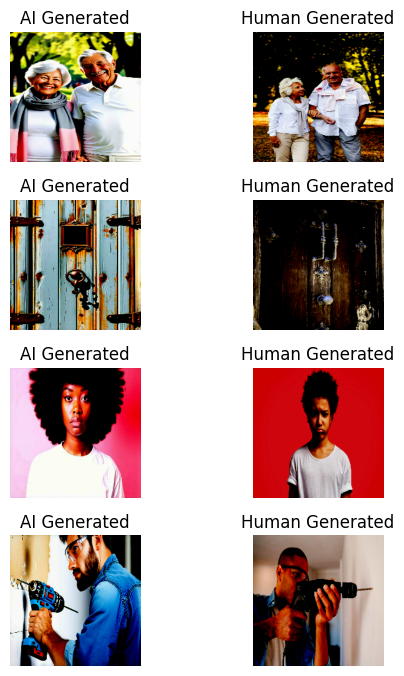

In [13]:
image_batch = batch[0]
label_batch = batch[1]

plt.figure(figsize=(5, 10))

for i in range(BATCH_SIZE):
    ax = plt.subplot(6, 2, BATCH_SIZE//2 + i + 1)
    plt.imshow(image_batch[i])
    plt.title(utils.id2label[label_batch[i].numpy()])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

## Aumento dos Dados

In [14]:
# Definindo camadas para Aumento de Dados. Tornar o Aumento dos Dados parte do modelo como camadas de pré-processamento permite que a GPU acelere o treinamento, já que as camadas de pré-processamento são executadas na GPU junto com o resto do modelo.
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),  
    ]
)

#### Visualizando o Aumento de Dados

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999454..0.9997411].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9981522..0.9993184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99844223..0.9987883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9993318..0.99829924].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99956536..0.9994971].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9989108..0.9985791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999

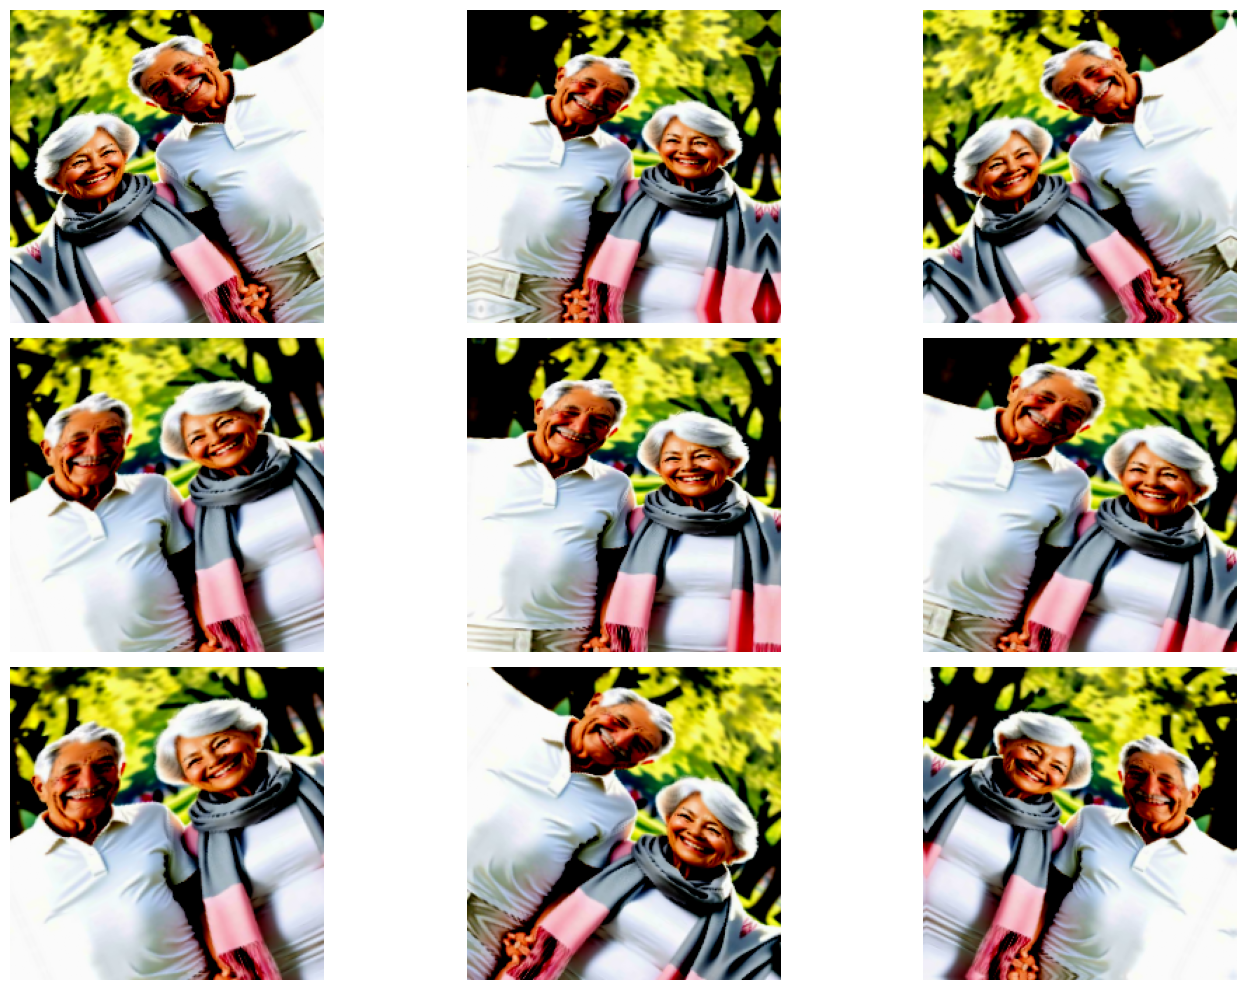

In [15]:
one_img = (image_batch[0]).numpy()

# Colocando em um batch
image = tf.expand_dims(one_img, 0)

plt.figure(figsize=(15, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## Construção do Modelo

### Definindo Callbacks

In [16]:
tf.keras.backend.clear_session()

tensorboard_path = 'logs/' + BASE_MODEL
path_best_model = 'models/' + BASE_MODEL + '.weights.h5'

In [17]:
# Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, write_graph=True, write_images=False)

# Reduzir a taxa de aprendizado
lr_control = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, mode='auto', min_delta=0.0001, min_lr=0)

# Parar o treinamento se não houver melhoria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1)

# Salvar o melhor modelo
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=path_best_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)

### Construindo o Modelo

In [18]:
def build_model():
    # Entrada do modelo
    input_layer = layers.Input(shape=(224, 224, 3), name='image')
    augmented_image = data_augmentation(input_layer)
    
    # MobileNet como base
    base_model = tf.keras.applications.MobileNetV2(input_tensor=augmented_image, include_top=False, weights='imagenet')
    base_model.trainable = False
    
    # Adicionando camadas de classificação
    x = layers.GlobalAveragePooling2D(name='Bloco_de_Classificacao_avg_pool')(base_model.output)
    x = layers.BatchNormalization(name='Bloco_de_Classificacao_bn')(x)
    # x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation='sigmoid', name='Bloco_de_Classificacao_output')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output, name=BASE_MODEL)
    return model


In [21]:
def compile_model(model, lr_inicial=0.001):
    
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.TruePositives(name='f1_score'),
    ]
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_inicial), loss='binary_crossentropy', metrics=metrics)
    
    return model

In [22]:
model = build_model()
model = compile_model(model)
model.summary()

/tmp/ipykernel_10599/3917370296.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_tensor=augmented_image, include_top=False, weights='imagenet')


Model: "mobilenet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ sequential[1][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,264,385 (8.64 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Treinamento do Modelo

In [40]:
print("Treinando novo Modelo")

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[tensorboard_callback, lr_control, early_stopping, checkpointer]
)

Treinando novo Modelo
Epoch 1/10


2025-02-12 16:02:01.162811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1739386921.387807   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.475337   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.476950   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.478625   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.480248   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.492920   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.494702   42134 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739386921.496489   42134 gpu_t

7994/7995 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8909 - auc: 0.9571 - loss: 0.2551 - precision: 0.8911 - recall: 0.8905

W0000 00:00:1739387248.952628   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.953978   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.955282   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.956605   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.957951   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.959349   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.960759   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.962128   42128 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1739387248.963495   42128 gp


Epoch 1: val_loss improved from inf to 0.39360, saving model to models/mobilenet_v2.weights.h5
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 333s 41ms/step - accuracy: 0.8909 - auc: 0.9571 - loss: 0.2551 - precision: 0.8911 - recall: 0.8905 - val_accuracy: 0.8615 - val_auc: 0.9584 - val_loss: 0.3936 - val_precision: 0.7989 - val_recall: 0.9664 - learning_rate: 0.0010
Epoch 2/10
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9203 - auc: 0.9754 - loss: 0.2031 - precision: 0.9211 - recall: 0.9193
Epoch 2: val_loss improved from 0.39360 to 0.38213, saving model to models/mobilenet_v2.weights.h5
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 331s 41ms/step - accuracy: 0.9203 - auc: 0.9754 - loss: 0.2031 - precision: 0.9211 - recall: 0.9193 - val_accuracy: 0.8639 - val_auc: 0.9585 - val_loss: 0.3821 - val_precision: 0.8046 - val_recall: 0.9614 - learning_rate: 0.0010
Epoch 3/10
7995/7995 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9215 - auc: 0.9767 - loss: 0.1975 - precision: 0.9218 - recall: 0.9210
Epoch

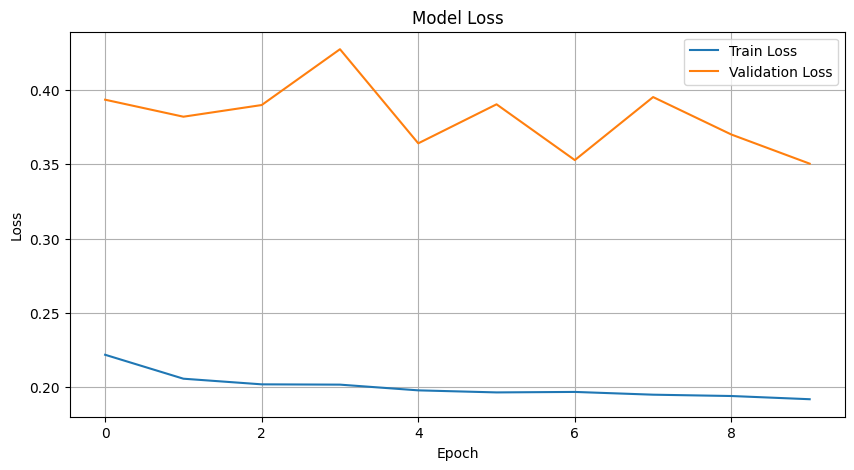

In [41]:
plt.figure(figsize=(10, 5))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

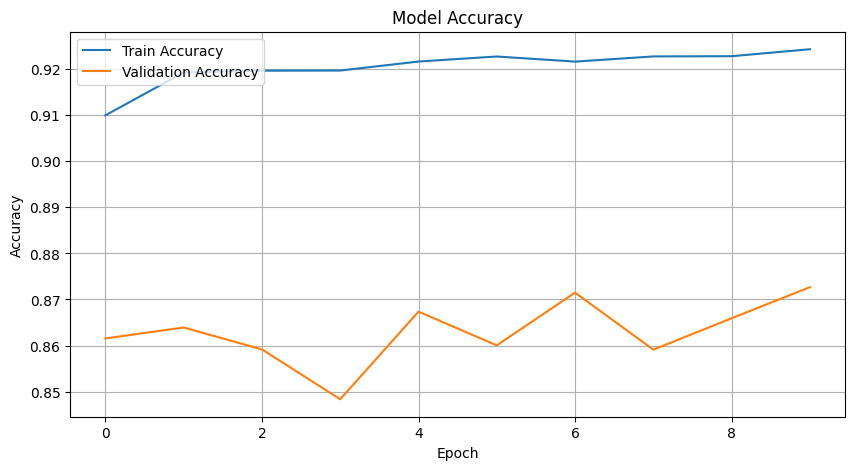

In [43]:
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Predição

In [23]:
# Carrega os pesos salvos
model.load_weights(path_best_model)

/home/penido/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
predictions = model.predict(test_ds)
test_ids = df_teste['id'].values

# Create a DataFrame to map each image path to its prediction
results_df = pd.DataFrame({'id': test_ids, 'label': predictions.flatten()})
results_df['label'] = results_df['label'].apply(lambda x: 1 if x >= 0.5 else 0)

In [28]:
print(results_df.shape)
results_df.head()

(5540, 2)


,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,1
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,1
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,1


In [29]:
results_df['label'].value_counts()

label
0    3151
1    2389
Name: count, dtype: int64

In [26]:
results_df.to_csv('submission/base_line.csv', index=False)